In [22]:
import numpy as np  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras import utils
from keras import backend as K
import matplotlib.pyplot as plt  
import math
import cv2


In [30]:
# dimensions of our images.
img_width, img_height = 64, 64

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'dataset/train'
validation_data_dir = 'dataset/valid'

# number of epochs to train top model
epochs = 100
# batch size used by flow_from_directory and predict_generator
batch_size = 16

In [31]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

print(len(generator.filenames))
print(generator.class_indices)
print(len(generator.class_indices))


Found 135 images belonging to 74 classes.
135
{'10': 0, '100': 1, '12': 2, '13': 3, '15': 4, '17': 5, '18': 6, '19': 7, '2': 8, '20': 9, '21': 10, '22': 11, '23': 12, '25': 13, '26': 14, '27': 15, '28': 16, '29': 17, '3': 18, '30': 19, '31': 20, '33': 21, '35': 22, '36': 23, '38': 24, '39': 25, '4': 26, '41': 27, '42': 28, '43': 29, '45': 30, '46': 31, '47': 32, '48': 33, '49': 34, '5': 35, '50': 36, '51': 37, '52': 38, '54': 39, '55': 40, '58': 41, '59': 42, '6': 43, '60': 44, '62': 45, '64': 46, '65': 47, '66': 48, '68': 49, '7': 50, '70': 51, '72': 52, '73': 53, '74': 54, '75': 55, '77': 56, '78': 57, '8': 58, '80': 59, '81': 60, '82': 61, '84': 62, '86': 63, '88': 64, '89': 65, '9': 66, '91': 67, '92': 68, '93': 69, '94': 70, '95': 71, '97': 72, '99': 73}
74


In [32]:

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = model.predict(
    generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_validation_samples = len(generator.filenames)

predict_size_validation = int(
    math.ceil(nb_validation_samples / batch_size))

bottleneck_features_validation = model.predict(
    generator, predict_size_validation)

np.save('bottleneck_features_validation.npy',
        bottleneck_features_validation)

9/9 [==============================] - 2s 257ms/step
Found 38 images belonging to 34 classes.
3/3 [==============================] - 1s 180ms/step


In [33]:
datagen_top = ImageDataGenerator(rescale=1. / 255)
generator_top = datagen_top.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

# save the class indices to use use later in predictions
np.save('class_indices.npy', generator_top.class_indices)


Found 135 images belonging to 74 classes.


In [34]:
# load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')

# get the class lebels for the training data, in the original order
train_labels = generator_top.classes

# https://github.com/fchollet/keras/issues/3467
# convert the training labels to categorical vectors
train_labels = utils.to_categorical(train_labels, num_classes=num_classes)

generator_top = datagen_top.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_validation_samples = len(generator_top.filenames)

validation_data = np.load('bottleneck_features_validation.npy')

validation_labels = generator_top.classes
validation_labels = utils.to_categorical(validation_labels, num_classes=num_classes)



Found 38 images belonging to 34 classes.


In [35]:
model = Sequential()

model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels))

model.save_weights(top_model_weights_path)

Epoch 1/100
9/9 [==============================] - 0s 19ms/step - loss: 4.5598 - acc: 0.0000e+00 - val_loss: 4.4024 - val_acc: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 4.2981 - acc: 0.0370 - val_loss: 4.3762 - val_acc: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 4.2720 - acc: 0.0222 - val_loss: 4.3618 - val_acc: 0.0263
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 4.2821 - acc: 0.0222 - val_loss: 4.3787 - val_acc: 0.0000e+00
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 4.2483 - acc: 0.0296 - val_loss: 4.4009 - val_acc: 0.0000e+00
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 4.2241 - acc: 0.0370 - val_loss: 4.4660 - val_acc: 0.0000e+00
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 4.2327 - acc: 0.0222 - val_loss: 4.4137 - val_acc: 0.0263
Epoch 8/100
9/9 [==============================] - 0s 7ms/step - loss: 4

3/3 [==============================] - 0s 2ms/step - loss: 5.6334 - acc: 0.0263
[INFO] accuracy: 2.63%
[INFO] Loss: 5.633444309234619


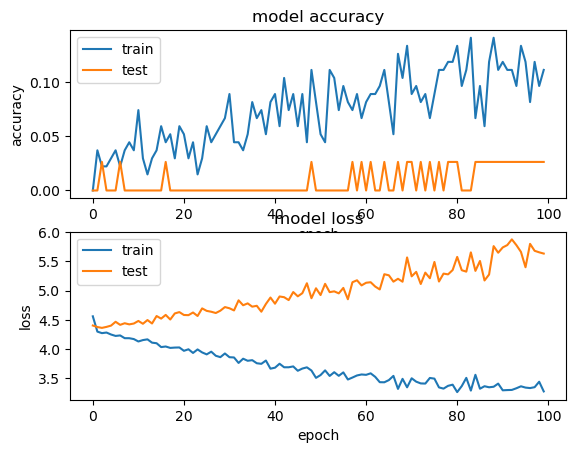

In [36]:
(eval_loss, eval_accuracy) = model.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

plt.figure(1)

# summarize history for accuracy
print(history)
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()